<a href="https://www.kaggle.com/code/jiwonkng/tabular-playground-apr-22?scriptVersionId=93516797" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


# Step 1. Library and Dataset

## Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import *
import seaborn as sns
from scipy.stats import kde, kurtosis
from scipy.stats.mstats import gmean


import os

print("Numpy ver.", np.__version__)
print("Pandas ver.", pd.__version__)
print("Matplotlib ver.", matplotlib.__version__)
print("Seaborn ver.", sns.__version__)

print(os.listdir('../input/tabular-playground-series-apr-2022'))

Numpy ver. 1.20.3
Pandas ver. 1.3.5
Matplotlib ver. 3.5.1
Seaborn ver. 0.11.2
['sample_submission.csv', 'train_labels.csv', 'train.csv', 'test.csv']


In [3]:
# !pip install pycaret==2.2.3

In [4]:
# from pycaret.utils import version
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [5]:
BASE_DIR = '../input/tabular-playground-series-apr-2022/'
train = pd.read_csv(BASE_DIR + "train.csv")
train_labels = pd.read_csv(BASE_DIR + "train_labels.csv")
test = pd.read_csv(BASE_DIR + "test.csv")
submission = pd.read_csv(BASE_DIR + "sample_submission.csv")
print("Train Data:",train.shape)
print("Train Label Data:",train_labels.shape)
print("Test Data:",test.shape)
print("Sample Data:",submission.shape)

Train Data: (1558080, 16)
Train Label Data: (25968, 2)
Test Data: (733080, 16)
Sample Data: (12218, 2)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


In [7]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25968 entries, 0 to 25967
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  25968 non-null  int64
 1   state     25968 non-null  int64
dtypes: int64(2)
memory usage: 405.9 KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733080 entries, 0 to 733079
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   733080 non-null  int64  
 1   subject    733080 non-null  int64  
 2   step       733080 non-null  int64  
 3   sensor_00  733080 non-null  float64
 4   sensor_01  733080 non-null  float64
 5   sensor_02  733080 non-null  float64
 6   sensor_03  733080 non-null  float64
 7   sensor_04  733080 non-null  float64
 8   sensor_05  733080 non-null  float64
 9   sensor_06  733080 non-null  float64
 10  sensor_07  733080 non-null  float64
 11  sensor_08  733080 non-null  float64
 12  sensor_09  733080 non-null  float64
 13  sensor_10  733080 non-null  float64
 14  sensor_11  733080 non-null  float64
 15  sensor_12  733080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 89.5 MB


In [9]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12218 entries, 0 to 12217
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  12218 non-null  int64
 1   state     12218 non-null  int64
dtypes: int64(2)
memory usage: 191.0 KB


In [10]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [11]:
train_labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [12]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [13]:
submission.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [14]:
# train = train.set_index(['sequence', 'subject', 'step'])
# test = test.set_index(['sequence', 'subject', 'step'])

# Step 2. EDA

## Overview of data

In [15]:
df = train.iloc[:,3:].describe()
display(df.style.format('{:,.2f}')\
        .background_gradient(subset=(df.index[1:], df.columns[:]),
                             cmap="RdBu", vmin=-700, vmax=700, axis=None))

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,"1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00"
mean,0.00,-0.00,-0.22,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.01
std,2.66,4.40,2.30,3.93,1.68,1.59,3.35,3.24,4.50,2.59,1.92,4.53,39.12
min,-375.06,-434.60,-31.66,-408.38,-23.63,-74.98,-470.50,-407.01,-536.10,-270.35,-43.41,-427.06,-612.55
25%,-0.50,-0.48,-0.65,-0.49,-0.47,-0.48,-0.49,-0.50,-0.50,-0.52,-0.48,-0.48,-0.58
50%,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
75%,0.48,0.49,0.33,0.49,0.47,0.51,0.49,0.48,0.50,0.51,0.48,0.49,0.57
max,335.82,449.59,1.67,436.65,24.87,77.92,442.50,331.25,630.10,367.98,41.87,448.02,630.51


In [16]:
df2 = test.iloc[:,3:].describe()
display(df2.style.format('{:,.2f}')\
        .background_gradient(subset=(df2.index[1:], df2.columns[:]),
                             cmap="RdBu", vmin=-700, vmax=700, axis=None))

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,"733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00"
mean,0.00,-0.00,-0.22,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
std,2.93,4.60,2.34,4.88,1.88,1.63,3.42,2.77,4.99,2.80,2.11,4.40,40.82
min,-347.38,-457.26,-31.66,-425.28,-24.75,-55.14,-435.77,-299.24,-544.90,-312.63,-43.73,-443.71,-572.73
25%,-0.50,-0.48,-0.58,-0.49,-0.52,-0.51,-0.49,-0.49,-0.50,-0.52,-0.49,-0.48,-0.87
50%,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
75%,0.48,0.49,0.33,0.48,0.52,0.53,0.49,0.48,0.50,0.51,0.49,0.49,0.87
max,403.79,551.54,1.67,498.47,24.54,62.82,484.38,324.04,769.60,306.49,39.19,375.81,536.12


In [17]:
missing = pd.DataFrame({
    'train_miss' : train.isna().sum(),
    'test_miss' : test.isna().sum(),
})
print("Missing Value :")
missing.T

Missing Value :


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
train_miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
test_miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Target Distribution

In [18]:
train = train.merge(train_labels, on='sequence')
train['state'].value_counts()

1    780840
0    777240
Name: state, dtype: int64

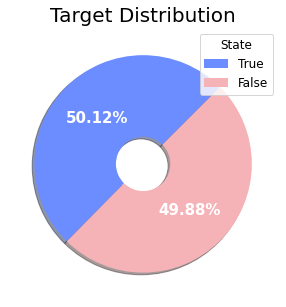

In [19]:
train_0 = train[train['state']==0]
train_1 = train[train['state']==1]

fig, ax = plt.subplots(figsize=(5,5))
labels = list(map(bool, train['state'].value_counts().index))
lst = train['state'].value_counts().to_list()

pie = ax.pie(lst, labels=labels, autopct='%.2f%%',
             textprops=dict(color="white", fontsize=15, weight="bold"),
             colors = ['#6B8DFF', '#F5B3B8'], shadow=True,
             wedgeprops=dict(width=0.75), startangle=45)
ax.set_title("Target Distribution", size=20)
ax.legend(title="State", title_fontsize=12, loc="best", fontsize=12)

plt.show()

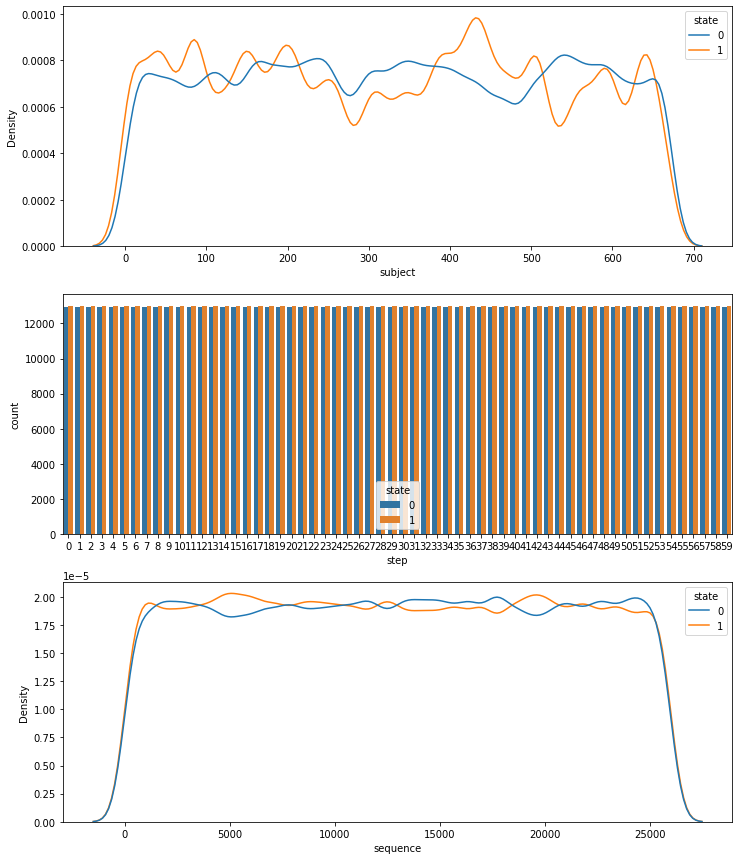

In [20]:
fig, axes = plt.subplots(3,1,figsize=(12,5*3))

sns.kdeplot(data=train,x='subject', hue='state', ax=axes[0])
sns.countplot(data=train,x='step', hue='state', ax=axes[1])
sns.kdeplot(data=train,x='sequence', hue='state', ax=axes[2])

plt.show()

## Sequence and Subject

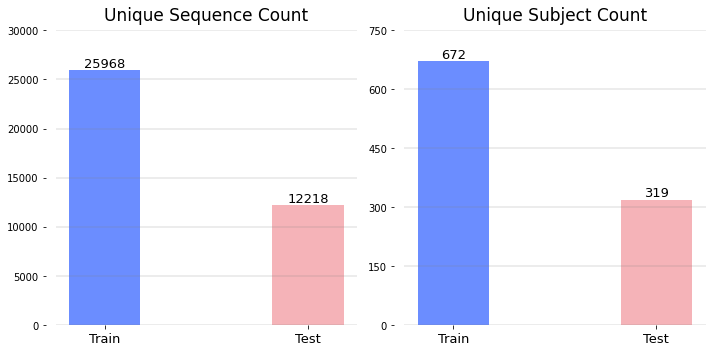

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

width = 0.35
labels = ["Train", "Test"]
colors = ['#6B8DFF', '#F5B3B8']

bar1 = ax[0].bar(range(len(labels)),
                 [train.sequence.nunique(), test.sequence.nunique()],
                 width, color = colors)
ax[0].bar_label(bar1, size=13)
ax[0].set_ylim(0,30000)
ax[0].yaxis.set_major_locator(MultipleLocator(5000))
ax[0].set_title("Unique Sequence Count", pad=10, fontsize=17)

bar2 = ax[1].bar(range(len(labels)),
                 [train.subject.nunique(), test.subject.nunique()],
                 width, color = colors)
ax[1].bar_label(bar2, size=13)
ax[1].set_ylim(0,750)
ax[1].yaxis.set_major_locator(MultipleLocator(150))
ax[1].set_title("Unique Subject Count", pad=10, fontsize=17)

for i in range(2):
    ax[i].set_xticks(range(len(labels)), labels, fontsize=13)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_position(("outward", 10))
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    
    ax[i].grid(axis="y", linewidth=0.3, color="gray")

fig.tight_layout()
plt.show()

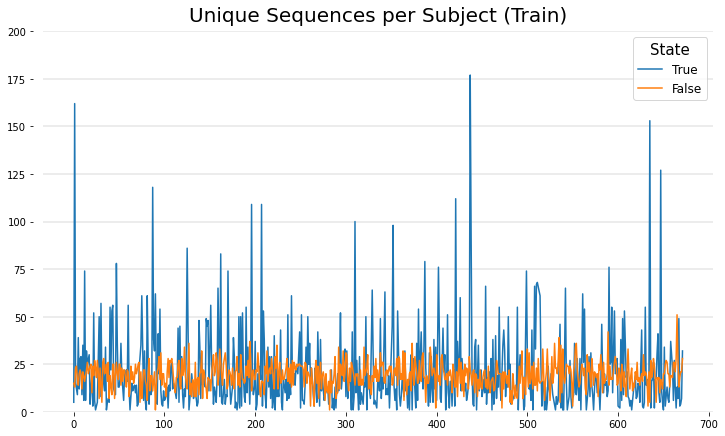

In [22]:
ss = train.groupby(['subject', 'state'])['sequence'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(12,7))

for i in reversed(range(0,2)):
    x = ss[ss['state']==i]['subject']
    y = ss[ss['state']==i]['sequence']
    ax.plot(x,y)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(("outward", 10))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(0,200)
ax.set_title("Unique Sequences per Subject (Train)", pad = 10, size=20)
ax.legend(['True', 'False'], title="State", title_fontsize=15,
          loc="upper right", fontsize=12)
ax.grid(axis="y", linewidth=0.3, color="gray")
plt.show()

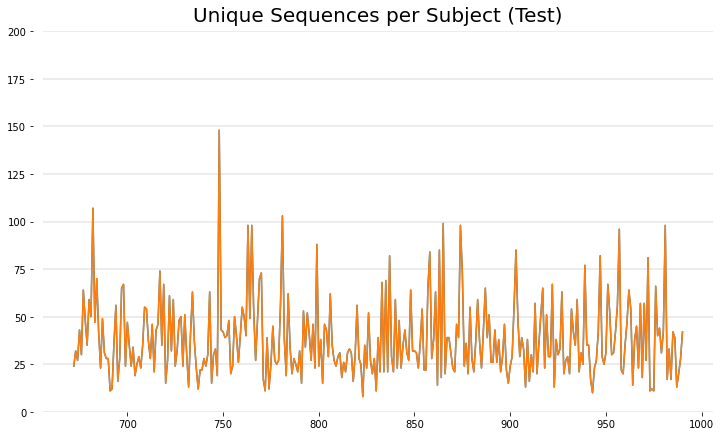

In [23]:
ss = test.groupby(['subject'])['sequence'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(12,7))

for i in reversed(range(0,2)):
    x = ss['subject']
    y = ss['sequence']
    ax.plot(x,y)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(("outward", 10))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(0,200)
ax.set_title("Unique Sequences per Subject (Test)", pad = 10, size=20)
ax.grid(axis="y", linewidth=0.3, color="gray")
plt.show()

## Sensors Ditributions

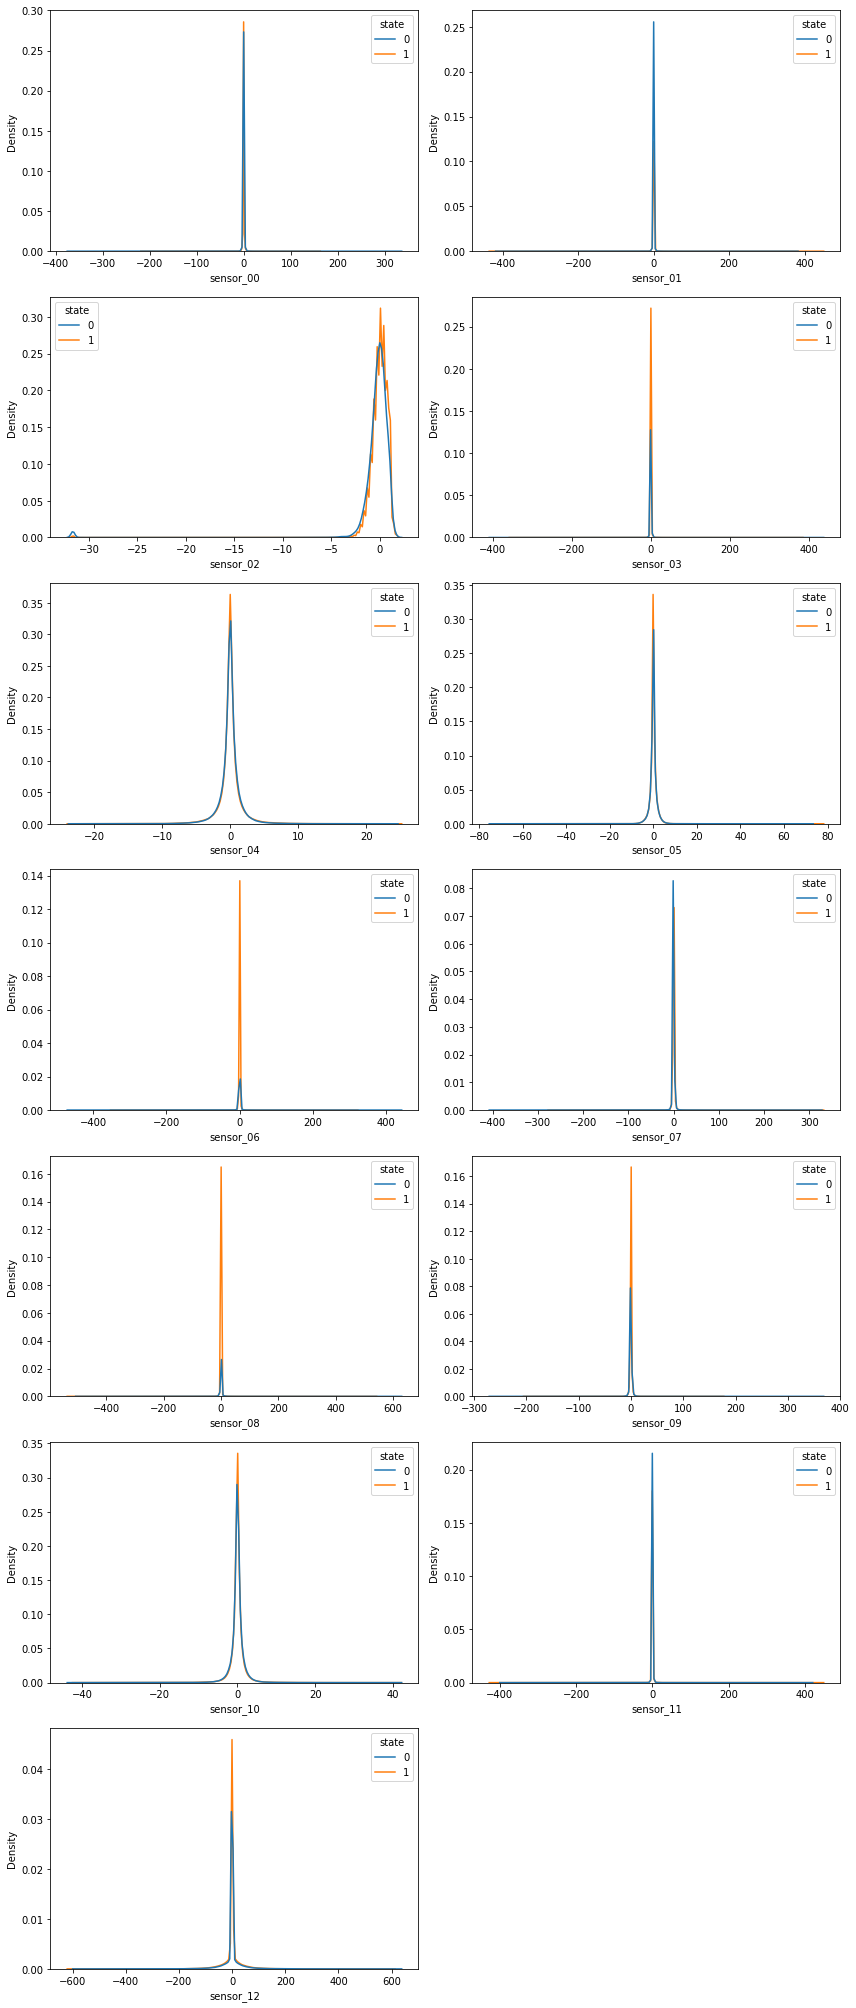

In [24]:
sensors = [col for col in train if col.startswith('sensor')]

fig, axes = plt.subplots(7, 2, figsize=(12, 7*4))

col, row = 0, 0
for sensor in sensors:
    sns.kdeplot(data=train, x=sensor, hue='state', ax=axes[row][col])
    col += 1
    if col >= 2:
        row += 1
        col = 0
        
axes[6,1].spines['top'].set_visible(False)
axes[6,1].spines['left'].set_visible(False)
axes[6,1].spines['right'].set_visible(False)
axes[6,1].spines['bottom'].set_visible(False)
axes[6,1].axis("off")

fig.tight_layout()
plt.show()

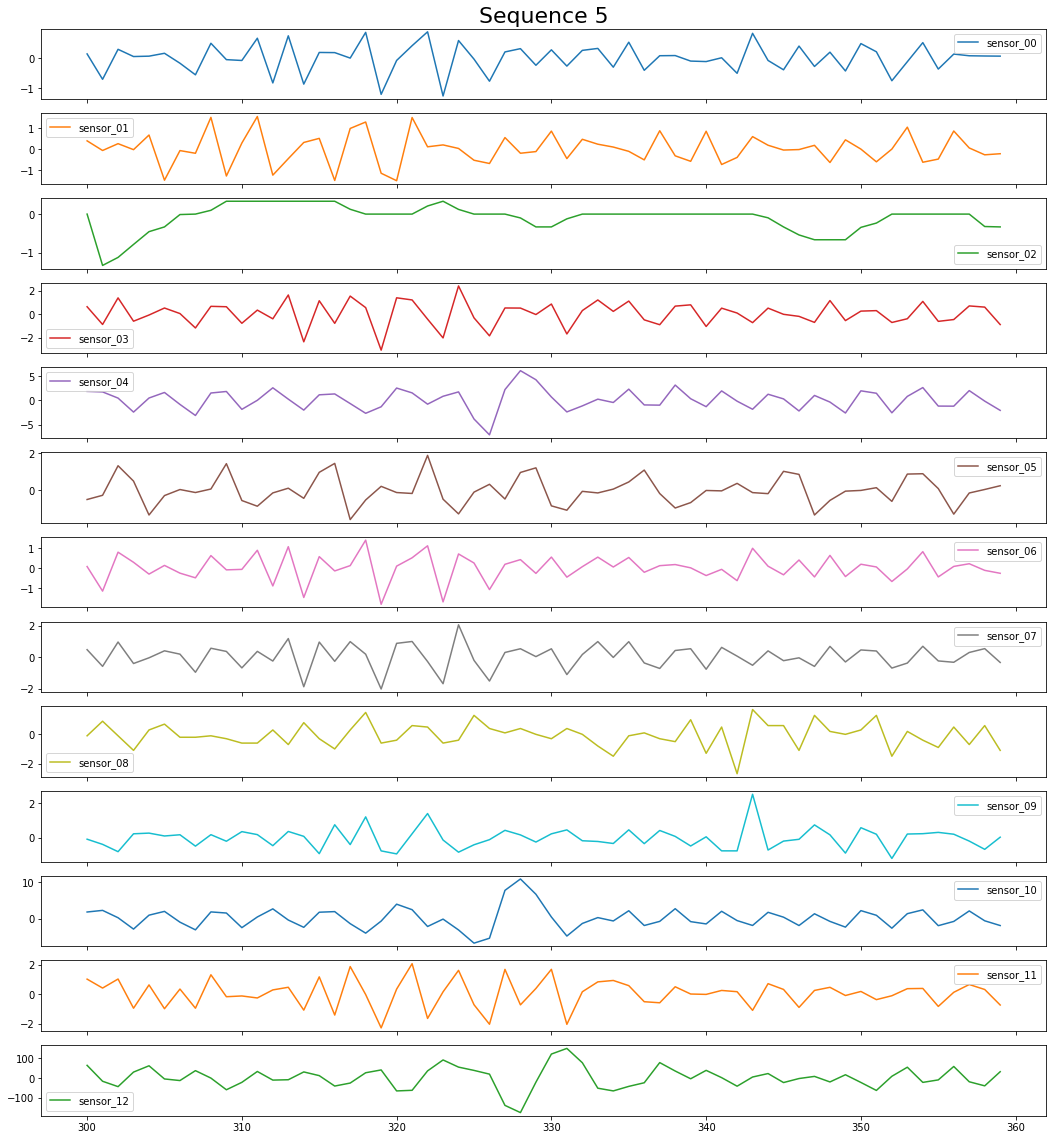

In [25]:
def plot_sequence(sequence: int) -> None:
    mask = train.sequence == sequence
    ax = train[mask][sensors].plot(subplots=True,
                                             sharex=True,
                                             figsize=(18, 20))
    ax[0].set_title(f'Sequence {sequence}', size=22)
    plt.show()

plot_sequence(5)

# Step 3. Feature Engineering

In [26]:
sensor = ['00','01','02','03','04','05','06','07','08','09','10','11','12']
for i in sensor:
    train[f'sensor_{i}_step_diff'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].diff()
    train[f'sensor_{i}_step_mean'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('mean')
    train[f'sensor_{i}_step_median'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('median')
    train[f'sensor_{i}_step_std'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('std')
    train[f'sensor_{i}_step_min'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('min')
    train[f'sensor_{i}_step_max'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('max')
    
    test[f'sensor_{i}_step_diff'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].diff()
    test[f'sensor_{i}_step_mean'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('mean')
    test[f'sensor_{i}_step_median'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('median')
    test[f'sensor_{i}_step_std'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('std')
    test[f'sensor_{i}_step_min'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('min')
    test[f'sensor_{i}_step_max'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('max')

In [27]:
'''sensor = ['00','01','02','03','04','05','06','07','08','09','10','11','12']
for i in sensor:
   train[f'sensor_{i}_kurtosis'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].kurtosis()'''

"sensor = ['00','01','02','03','04','05','06','07','08','09','10','11','12']\nfor i in sensor:\n   train[f'sensor_{i}_kurtosis'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].kurtosis()"

# Step 4. Modeling

## Data Split

In [28]:
y = train['state'].copy()
X = train.drop('state', axis=1).copy()
X_test = test.copy()

In [29]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
print("Train data\t:", X_train.shape, y_train.shape)
print("Validation data\t:", X_val.shape, y_val.shape)

Train data	: (1090656, 94) (1090656,)
Validation data	: (467424, 94) (467424,)


## Pycaret

In [30]:
'''from pycaret.classification import *
setup_clf = setup(data=train, target='state')'''

"from pycaret.classification import *\nsetup_clf = setup(data=train, target='state')"

In [31]:
'''best_model = compare_models(sort='AUC', fold=5,
                            include=['rf', 'knn', 'lr', 'svm', 'lightgbm'])'''

"best_model = compare_models(sort='AUC', fold=5,\n                            include=['rf', 'knn', 'lr', 'svm', 'lightgbm'])"

In [32]:
'''pred = predict_model(best_model, data=test)
pred.head()'''

'pred = predict_model(best_model, data=test)\npred.head()'

## Hyperparameter Tuning

### Grid Search

In [33]:
'''# define classifier
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42),
    "LGBM" : LGBMClassifier(random_state=42),
    "SVM" : SVC(random_state=42)
}

# define grid
KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25],
           'max_iter': [50, 100, 150]}

RF_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [6, 8, 10, 12]}

LGBM_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [6, 8, 10, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

SVM_grid = [{'svc__C': [0.01, 0.1, 1.0, 10.0],
             'svc__kernel': ['linear']},
            {'svc__C': [0.01, 0.1, 1.0, 10.0],
             'svc__gamma': [0.01, 0.1, 1.0, 10.0],
             'svc__kernel': ['rbf']}]

grid = {
    "KNN" : KNN_grid,
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "LGBM" : LGBM_grid,
    "SVM" : SVM_grid
}'''

'# define classifier\nclassifiers = {\n    "KNN" : KNeighborsClassifier(),\n    "LogisticRegression" : LogisticRegression(random_state=42),\n    "RandomForest" : RandomForestClassifier(random_state=42),\n    "LGBM" : LGBMClassifier(random_state=42),\n    "SVM" : SVC(random_state=42)\n}\n\n# define grid\nKNN_grid = {\'n_neighbors\': [3, 5, 7, 9],\n            \'p\': [1, 2]}\n\nLR_grid = {\'penalty\': [\'l1\',\'l2\'],\n           \'C\': [0.25, 0.5, 0.75, 1, 1.25],\n           \'max_iter\': [50, 100, 150]}\n\nRF_grid = {\'n_estimators\': [50, 100, 150, 200],\n        \'max_depth\': [6, 8, 10, 12]}\n\nLGBM_grid = {\'n_estimators\': [50, 100, 150, 200],\n        \'max_depth\': [6, 8, 10, 12],\n        \'learning_rate\': [0.05, 0.1, 0.15]}\n\nSVM_grid = [{\'svc__C\': [0.01, 0.1, 1.0, 10.0],\n             \'svc__kernel\': [\'linear\']},\n            {\'svc__C\': [0.01, 0.1, 1.0, 10.0],\n             \'svc__gamma\': [0.01, 0.1, 1.0, 10.0],\n             \'svc__kernel\': [\'rbf\']}]\n\ngrid = {

In [34]:
'''i=0
clf_best_params = classifiers.copy()
scores = pd.DataFrame({
                    'Classifer':classifiers.keys(),
                    'Train accuracy' : np.zeros(len(classifiers)),
                    'Validation accuracy': np.zeros(len(classifiers)),
                    'Training time': np.zeros(len(classifiers))
                    })

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    clf.fit(X_train, y_train)
    scores.iloc[i,1]=clf.score(X_train, y_train)
    scores.iloc[i,2]=clf.score(X_val, y_val)
    clf_best_params[key]=clf.best_params_
    
    stop = time.time()
    scores.iloc[i,3]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', scores.iloc[i,3])
    print('')
    i+=1'''

"i=0\nclf_best_params = classifiers.copy()\nscores = pd.DataFrame({\n                    'Classifer':classifiers.keys(),\n                    'Train accuracy' : np.zeros(len(classifiers)),\n                    'Validation accuracy': np.zeros(len(classifiers)),\n                    'Training time': np.zeros(len(classifiers))\n                    })\n\nfor key, classifier in classifiers.items():\n    start = time.time()\n    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)\n\n    clf.fit(X_train, y_train)\n    scores.iloc[i,1]=clf.score(X_train, y_train)\n    scores.iloc[i,2]=clf.score(X_val, y_val)\n    clf_best_params[key]=clf.best_params_\n    \n    stop = time.time()\n    scores.iloc[i,3]=np.round((stop - start)/60, 2)\n    \n    print('Model:', key)\n    print('Training time (mins):', scores.iloc[i,3])\n    print('')\n    i+=1"

### Random Search

In [35]:
'''# define classifier
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42),
    "LGBM" : LGBMClassifier(random_state=42),
    "SVM" : SVC(random_state=42)
}

# define grid
KNN_grid = {'n_neighbors': randint(3,9),
            'p': randint(1,2)}

LR_grid = {'penalty': ['l1','l2'],
           'C': uniform(0.25, 1.25),
           'max_iter': randint(50,150)}

RF_grid = {'n_estimators': randint(50,200),
        'max_depth': randint(4,12)}

LGBM_grid = {'n_estimators': randint(50,200),
        'max_depth': randint(4,12),
        'learning_rate': uniform(0.05, 0.15)}

SVM_grid = [{'svc__C': uniform(0.1, 10.0),
             'svc__kernel': ['linear']},
            {'svc__C': uniform(0.1, 10.0),
             'svc__gamma': uniform(0.1, 10.0),
             'svc__kernel': ['rbf']}]

grid = {
    "KNN" : KNN_grid,
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "LGBM" : LGBM_grid,
    "SVM" : SVM_grid
}'''

'# define classifier\nclassifiers = {\n    "KNN" : KNeighborsClassifier(),\n    "LogisticRegression" : LogisticRegression(random_state=42),\n    "RandomForest" : RandomForestClassifier(random_state=42),\n    "LGBM" : LGBMClassifier(random_state=42),\n    "SVM" : SVC(random_state=42)\n}\n\n# define grid\nKNN_grid = {\'n_neighbors\': randint(3,9),\n            \'p\': randint(1,2)}\n\nLR_grid = {\'penalty\': [\'l1\',\'l2\'],\n           \'C\': uniform(0.25, 1.25),\n           \'max_iter\': randint(50,150)}\n\nRF_grid = {\'n_estimators\': randint(50,200),\n        \'max_depth\': randint(4,12)}\n\nLGBM_grid = {\'n_estimators\': randint(50,200),\n        \'max_depth\': randint(4,12),\n        \'learning_rate\': uniform(0.05, 0.15)}\n\nSVM_grid = [{\'svc__C\': uniform(0.1, 10.0),\n             \'svc__kernel\': [\'linear\']},\n            {\'svc__C\': uniform(0.1, 10.0),\n             \'svc__gamma\': uniform(0.1, 10.0),\n             \'svc__kernel\': [\'rbf\']}]\n\ngrid = {\n    "KNN" : KNN_gr

In [36]:
'''i=0
clf_best_params = classifiers.copy()
scores = pd.DataFrame({
                    'Classifer':classifiers.keys(),
                    'Train accuracy' : np.zeros(len(classifiers)),
                    'Validation accuracy': np.zeros(len(classifiers)),
                    'Training time': np.zeros(len(classifiers))
                    })

for key, classifier in classifiers.items():
    start = time.time()
    clf = RandomizedSearchCV(estimator=classifier, param_distributions=grid[key], n_jobs=-1, n_iter=100)

    clf.fit(X_train, y_train)
    scores.iloc[i,1]=clf.score(X_train, y_train)
    scores.iloc[i,2]=clf.score(X_val, y_val)
    clf_best_params[key]=clf.best_params_
    
    stop = time.time()
    scores.iloc[i,3]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', scores.iloc[i,3])
    print('')
    i+=1'''

"i=0\nclf_best_params = classifiers.copy()\nscores = pd.DataFrame({\n                    'Classifer':classifiers.keys(),\n                    'Train accuracy' : np.zeros(len(classifiers)),\n                    'Validation accuracy': np.zeros(len(classifiers)),\n                    'Training time': np.zeros(len(classifiers))\n                    })\n\nfor key, classifier in classifiers.items():\n    start = time.time()\n    clf = RandomizedSearchCV(estimator=classifier, param_distributions=grid[key], n_jobs=-1, n_iter=100)\n\n    clf.fit(X_train, y_train)\n    scores.iloc[i,1]=clf.score(X_train, y_train)\n    scores.iloc[i,2]=clf.score(X_val, y_val)\n    clf_best_params[key]=clf.best_params_\n    \n    stop = time.time()\n    scores.iloc[i,3]=np.round((stop - start)/60, 2)\n    \n    print('Model:', key)\n    print('Training time (mins):', scores.iloc[i,3])\n    print('')\n    i+=1"

In [37]:
# clf_best_params

In [38]:
# scores

## Multiple Modeling

In [39]:
'''classifiers = [
    LogisticRegression(),
    LGBMClassifier(random_state=42),
    SVC(random_state=42)
]'''

'classifiers = [\n    LogisticRegression(),\n    LGBMClassifier(random_state=42),\n    SVC(random_state=42)\n]'

In [40]:
'''FOLDS = 5
val_preds = []
test_preds = []

for classifier in classifiers:
    print(classifier)
    model = classifier.fit(X_train, y_train)
    val_preds.append(model.predict(X_val))
    test_preds.append(model.predict(X_test))
    
    splitter = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state=42)
    scores = cross_validate(classifier, X_train, y_train, return_train_score = True, cv=splitter)
    print("\t", np.mean(scores['train_score']), np.mean(scores['test_score']), "\n")'''

'FOLDS = 5\nval_preds = []\ntest_preds = []\n\nfor classifier in classifiers:\n    print(classifier)\n    model = classifier.fit(X_train, y_train)\n    val_preds.append(model.predict(X_val))\n    test_preds.append(model.predict(X_test))\n    \n    splitter = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state=42)\n    scores = cross_validate(classifier, X_train, y_train, return_train_score = True, cv=splitter)\n    print("\t", np.mean(scores[\'train_score\']), np.mean(scores[\'test_score\']), "\n")'

## Logistic Regression

In [41]:
'''lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)'''

'lr = LogisticRegression()\n\nlr.fit(X_train, y_train)\ny_pred = lr.predict(X_val)'

In [42]:
'''splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
scores = cross_validate(lr, X_train, y_train, return_train_score = True, cv=splitter)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))'''

"splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)\nscores = cross_validate(lr, X_train, y_train, return_train_score = True, cv=splitter)\n\nprint(np.mean(scores['train_score']), np.mean(scores['test_score']))"

## LightGBM

In [43]:
lgb = LGBMClassifier(random_state=42)

splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.881082577824722 0.8792754085614529


In [44]:
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)

In [45]:
pd.DataFrame(confusion_matrix(y_val, y_pred),
                index = [["actual", "actual"], ["N", "P"]],
                columns = [["pred", "pred"], ["N", "P"]])

pred        
               N       P
actual N  195876   37127
       P   18831  215590

In [46]:
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))

Acc. : 0.8802842815088656
Prec. : 0.8530886327393883
Recall : 0.9196701660687395
f1. : 0.8851290599378411


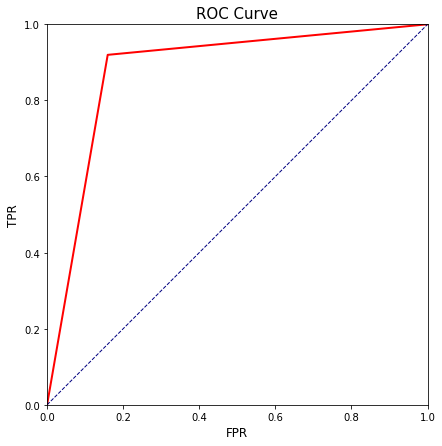

AUC Score: 0.8801644350169623


In [47]:
fig, ax = plt.subplots(figsize=(7,7))

fpr, tpr, _ = roc_curve(y_val, y_pred)
ax.plot(fpr, tpr, color='r', lw=2)
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.gca().set_aspect('equal')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("FPR", size=12)
ax.set_ylabel("TPR", size=12)
ax.set_title("ROC Curve", size=15)

plt.show()

print("AUC Score:", roc_auc_score(y_val, y_pred))

# Step 5. Submission

In [48]:
lgb_test= lgb.predict(test)
pred = pd.DataFrame({"sequence":test['sequence'],
              "state":lgb_test.tolist()})

In [49]:
pred_fin = pred.groupby('sequence').mean().reset_index()
for i in pred_fin.index.to_list():
    if pred_fin.iloc[i,1] != 0:
        pred_fin.iloc[i,1] = 1
pred_fin['state'].value_counts()

1.0    6136
0.0    6082
Name: state, dtype: int64

In [50]:
submission['state'] = pred_fin['state'].astype(int)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12218 entries, 0 to 12217
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  12218 non-null  int64
 1   state     12218 non-null  int64
dtypes: int64(2)
memory usage: 191.0 KB


In [51]:
submission.to_csv('submission.csv', index=False)